# Project 3 to use ML to predict stock prices
1. read SP 500
2. Find Corrleation between price
3. Experiment to see if corrleated on uncorrlated prices have ino
4. PCA on prices
5. LSTM - Multip Period multi task
6. IBM Info
7. Other ML Methods


# Models
Section 1. Read SP 500
    - need to do real time from Alpaca
Section 2. Correlation experiements
    - drop corrleated elements?
Section 3 Set up LSTM
Section 4 Read News API
Section 5 IBM Tone Analysis

### Project Notes
Read SP 500 - v1.2<br>
Correllation Experiments:<br>
    fraction change and % change have same correlation matrix<br>
    log fraction change almost same corrleation matrix as %change<br>
V 1.2:<br>
    - got lstm working<br>
    - inverse scaling not working<br>
        - seems to be that information of scaling is not preserved when passing through function or return the scalers through funcitons<br>
v 1.4: <br>
    - include entire lstm code in one module to see how it modularized Section 3.4<br>
    - v1.4.1fixed by changed number of dropped columns<br>
    - need to make it into a function<br>
v 1.5: <br>
    - add newsfeed.<br>
    - news feed donedone can only do one month for free <br>
    - now to merge news with data
v 1.6: <br>
    - added IBM Tone.
    
V 1.7 Integrate the systems..
    
    
To do:<br>
    - make LSTM a function call.<br>
    - figure out why LSTM dropping some columns<br>
    - Connect to Alpaca live<br>
    - need to get news api for more than one month with paid input

New order of moduels
1. Read Stock prices
2. read news areticles
3. Code sentiment of articles
4. Join stock prices and sentiment
5. Feed into LSTM model


In [1]:
import alpaca_trade_api as tradeapi
import json
import numpy as np
import os
import pandas as pd
import requests

from datetime import datetime
from datetime import date
from dotenv import load_dotenv
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import concatenate
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas.io.json import json_normalize
import pandas as pd
from pandas import read_csv
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [60]:
# Initial imports
import os
import json
# deoes not work use next cell
# from pandas import json_normalize
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from pandas.io.json import json_normalize
from dotenv import load_dotenv
load_dotenv()
load_dotenv('ibm-credentials.env')

True

In [1]:
load_dotenv('test1.env')

NameError: name 'load_dotenv' is not defined

## Sectioin 1. Read SP 500
In this case from stored files. Do for real time with Alpaca

In [2]:
# csv_path = Path("../Resources/trading_signals.csv")
csv_path = Path ("./sp500_close_2020-2021.csv", infer_datetime_format = True,  parse_dates=True, index_col='time')
SP500_close = read_csv(csv_path)
# raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')
SP500_close['time'] = pd.to_datetime (SP500_close['time'])
SP500_close.set_index('time', inplace = True)
# SP500_close = SP500_close.iloc[:, 1:]
SP500_close.head()


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 05:00:00+00:00,85.95,29.09,159.40,300.58,89.57,85.09,168.81,86.94,210.15,334.48,...,62.38,101.69,70.900,56.94,79.87,102.18,149.20,259.14,52.44,134.150
2020-01-03 05:00:00+00:00,84.53,27.65,159.48,297.38,88.67,83.99,166.75,85.84,209.76,331.71,...,62.68,99.31,70.320,56.30,80.29,101.84,148.75,256.10,51.70,134.110
2020-01-06 05:00:00+00:00,84.78,27.32,156.82,299.78,89.40,85.25,179.07,86.33,208.43,333.71,...,62.59,97.23,70.870,56.61,79.81,101.79,147.95,258.01,51.07,133.100
2020-01-07 05:00:00+00:00,85.09,27.22,154.95,298.27,88.87,84.63,180.36,85.87,203.92,333.51,...,62.46,99.46,70.280,56.91,79.50,101.97,147.83,256.47,50.74,133.600
2020-01-08 05:00:00+00:00,85.91,27.84,153.15,303.15,89.52,85.45,178.72,86.21,204.37,337.92,...,62.42,99.19,69.235,57.51,79.78,102.14,149.59,247.63,51.26,133.325


In [3]:
# need to rearrang this because it is multi-level
# df = pd.read_csv(pd.compat.StringIO(temp), header=[0,1], index_col=[0])
csv_path = Path ("./sp500_2020-2021.csv",header=[0,1])
SP500_all = read_csv(csv_path)
SP500_all.head(5)

,Unnamed: 0,A,A.1,A.2,A.3,A.4,AAL,AAL.1,AAL.2,AAL.3,...,ZION,ZION.1,ZION.2,ZION.3,ZION.4,ZTS,ZTS.1,ZTS.2,ZTS.3,ZTS.4
0,NaN,open,high,low,close,volume,open,high,low,close,...,open,high,low,close,volume,open,high,low,close,volume
1,time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 05:00:00+00:00,85.9,86.35,85.2,85.95,1199810,28.98,29.295,28.65,29.09,...,52.36,52.48,51.79,52.44,1307412,132.05,134.28,131.48,134.15,1308668
3,2020-01-03 05:00:00+00:00,84.67,85.33,84.5,84.53,895182,28.27,28.29,27.34,27.65,...,51.41,51.89,51.16,51.7,1012303,132.48,134.91,132.27,134.11,1038786
4,2020-01-06 05:00:00+00:00,84.0,84.82,83.6,84.78,1380173,27.19,27.4901,27.08,27.32,...,51.08,51.68,50.805,51.07,1048073,133.78,134.065,132.71,133.1,1259478


##2.  Find Correlation between prices
1. create % change 
2. create fraction of change
2. create log # fraction change
3. calculate correlation of %change
3. calculate correlatio of fraction change
4. calculate correlation of log #change


In [4]:
df_pct_change = SP500_close.pct_change().dropna(how='all')
# SP500_close.pct_change()
df_pct_change.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
time,,,,,,,,,,,,,,,,,,,,,
2020-01-03 05:00:00+00:00,-0.016521,-0.049502,0.000502,-0.010646,-0.010048,-0.012927,-0.012203,-0.012652,-0.001856,-0.008282,...,0.004809,-0.023404,-0.008181,-0.011240,0.005259,-0.003327,-0.003016,-0.011731,-0.014111,-0.000298
2020-01-06 05:00:00+00:00,0.002958,-0.011935,-0.016679,0.008070,0.008233,0.015002,0.073883,0.005708,-0.006341,0.006029,...,-0.001436,-0.020945,0.007821,0.005506,-0.005978,-0.000491,-0.005378,0.007458,-0.012186,-0.007531
2020-01-07 05:00:00+00:00,0.003657,-0.003660,-0.011924,-0.005037,-0.005928,-0.007273,0.007204,-0.005328,-0.021638,-0.000599,...,-0.002077,0.022935,-0.008325,0.005299,-0.003884,0.001768,-0.000811,-0.005969,-0.006462,0.003757
2020-01-08 05:00:00+00:00,0.009637,0.022777,-0.011617,0.016361,0.007314,0.009689,-0.009093,0.003959,0.002207,0.013223,...,-0.000640,-0.002715,-0.014869,0.010543,0.003522,0.001667,0.011906,-0.034468,0.010248,-0.002058
2020-01-09 05:00:00+00:00,0.015714,0.003951,-0.001763,0.021639,0.007708,0.014160,0.028424,0.002552,0.009003,0.007487,...,0.001922,0.023490,0.007727,0.000869,0.004387,0.008028,-0.006752,-0.004563,0.006828,0.013163


In [5]:
SP500_close.head(5)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 05:00:00+00:00,85.95,29.09,159.40,300.58,89.57,85.09,168.81,86.94,210.15,334.48,...,62.38,101.69,70.900,56.94,79.87,102.18,149.20,259.14,52.44,134.150
2020-01-03 05:00:00+00:00,84.53,27.65,159.48,297.38,88.67,83.99,166.75,85.84,209.76,331.71,...,62.68,99.31,70.320,56.30,80.29,101.84,148.75,256.10,51.70,134.110
2020-01-06 05:00:00+00:00,84.78,27.32,156.82,299.78,89.40,85.25,179.07,86.33,208.43,333.71,...,62.59,97.23,70.870,56.61,79.81,101.79,147.95,258.01,51.07,133.100
2020-01-07 05:00:00+00:00,85.09,27.22,154.95,298.27,88.87,84.63,180.36,85.87,203.92,333.51,...,62.46,99.46,70.280,56.91,79.50,101.97,147.83,256.47,50.74,133.600
2020-01-08 05:00:00+00:00,85.91,27.84,153.15,303.15,89.52,85.45,178.72,86.21,204.37,337.92,...,62.42,99.19,69.235,57.51,79.78,102.14,149.59,247.63,51.26,133.325


In [6]:
SP500_close.shift().head(5)
df_change = SP500_close/SP500_close.shift()
df_log_change = np.log(SP500_close/SP500_close.shift())


## Section 2. Compute Correlation

In [7]:
df_pct_chgn_corr = df_pct_change.corr()
df_pct_chgn_corr.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.443147,0.587213,0.819997,0.712706,0.728070,0.413968,0.811056,0.787407,0.770909,...,0.716087,0.752732,0.702827,0.641173,0.820087,0.531354,0.523467,0.815339,0.745251,0.802476
AAL,0.443147,1.000000,0.480130,0.430385,0.305095,0.333133,0.359150,0.343987,0.462813,0.267602,...,0.342449,0.296774,0.556822,0.438173,0.536077,0.560906,0.564832,0.415976,0.467171,0.400790
AAP,0.587213,0.480130,1.000000,0.669217,0.612972,0.615328,0.473498,0.627349,0.658271,0.608786,...,0.732604,0.614714,0.600658,0.668102,0.730170,0.671056,0.514705,0.608947,0.634158,0.694887
AAPL,0.819997,0.430385,0.669217,1.000000,0.773732,0.780393,0.476349,0.833286,0.836114,0.867310,...,0.742790,0.742768,0.684204,0.653211,0.805362,0.645901,0.590922,0.810612,0.709257,0.815236
ABBV,0.712706,0.305095,0.612972,0.773732,1.000000,0.753287,0.287458,0.738075,0.773401,0.715894,...,0.649230,0.595783,0.614664,0.729269,0.740274,0.572992,0.597597,0.677072,0.664435,0.776426


In [8]:
df_change_corr = df_change.corr()
df_change_corr.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.443147,0.587213,0.819997,0.712706,0.728070,0.413968,0.811056,0.787407,0.770909,...,0.716087,0.752732,0.702827,0.641173,0.820087,0.531354,0.523467,0.815339,0.745251,0.802476
AAL,0.443147,1.000000,0.480130,0.430385,0.305095,0.333133,0.359150,0.343987,0.462813,0.267602,...,0.342449,0.296774,0.556822,0.438173,0.536077,0.560906,0.564832,0.415976,0.467171,0.400790
AAP,0.587213,0.480130,1.000000,0.669217,0.612972,0.615328,0.473498,0.627349,0.658271,0.608786,...,0.732604,0.614714,0.600658,0.668102,0.730170,0.671056,0.514705,0.608947,0.634158,0.694887
AAPL,0.819997,0.430385,0.669217,1.000000,0.773732,0.780393,0.476349,0.833286,0.836114,0.867310,...,0.742790,0.742768,0.684204,0.653211,0.805362,0.645901,0.590922,0.810612,0.709257,0.815236
ABBV,0.712706,0.305095,0.612972,0.773732,1.000000,0.753287,0.287458,0.738075,0.773401,0.715894,...,0.649230,0.595783,0.614664,0.729269,0.740274,0.572992,0.597597,0.677072,0.664435,0.776426


In [9]:
df_log_chng_corr = df_log_change.corr()
df_log_chng_corr.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.447760,0.581251,0.818401,0.712669,0.717333,0.414445,0.805092,0.789330,0.770999,...,0.700958,0.744983,0.709445,0.648652,0.812906,0.542518,0.537930,0.814061,0.750312,0.801734
AAL,0.447760,1.000000,0.471541,0.416506,0.299832,0.334056,0.345857,0.319942,0.460006,0.280687,...,0.335307,0.294660,0.553593,0.435042,0.547236,0.525348,0.552695,0.411514,0.464487,0.384022
AAP,0.581251,0.471541,1.000000,0.674323,0.625709,0.617600,0.473615,0.626373,0.655899,0.624832,...,0.745070,0.611149,0.604328,0.676629,0.737239,0.667077,0.508707,0.609771,0.629720,0.691378
AAPL,0.818401,0.416506,0.674323,1.000000,0.780399,0.780847,0.468285,0.830937,0.837551,0.873413,...,0.744959,0.739347,0.694480,0.668258,0.804657,0.651628,0.598214,0.808067,0.715565,0.818120
ABBV,0.712669,0.299832,0.625709,0.780399,1.000000,0.756530,0.286213,0.741185,0.771540,0.726565,...,0.655394,0.596115,0.622101,0.738113,0.742644,0.587713,0.603224,0.679809,0.668854,0.788051


In [10]:
df_dif_pct_chng_chg = df_pct_chgn_corr - df_change_corr
df_dif_pct_chng_chg.max().sort_values()

OTIS    2.220446e-16
IR      2.220446e-16
NLOK    2.498002e-16
CARR    3.330669e-16
HWM     3.330669e-16
            ...     
DOV     1.332268e-15
F       1.332268e-15
LUMN             NaN
OGN              NaN
VTRS             NaN
Length: 505, dtype: float64

In [11]:
df_dif_pct_chng_log_chng = df_pct_chgn_corr - df_log_chng_corr
df_dif_pct_chng_log_chng.max().sort_values()

CARR    0.015843
KR      0.019835
HWM     0.024264
CLX     0.031830
RTX     0.035876
          ...   
PH      0.161192
IR      0.161192
LUMN         NaN
OGN          NaN
VTRS         NaN
Length: 505, dtype: float64

## Section 3. Set Up LSTM

### 3.1 create some data here from previous section.
can do as any number of data in the section below

In [12]:
num_of_cols = 5
raw_df = df_log_change.iloc[:, : num_of_cols]
raw_df.head()

,A,AAL,AAP,AAPL,ABBV
time,,,,,
2020-01-02 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-01-03 05:00:00+00:00,-0.016659,-0.050769,0.000502,-0.010703,-0.010099
2020-01-06 05:00:00+00:00,0.002953,-0.012007,-0.016820,0.008038,0.008199
2020-01-07 05:00:00+00:00,0.003650,-0.003667,-0.011996,-0.005050,-0.005946
2020-01-08 05:00:00+00:00,0.009591,0.022522,-0.011685,0.016229,0.007287


In [137]:
date_index_df = raw_df.copy()
# test.index = pd.to_datetime(test.index, format = '%Y-%m-%d')
date_index_df.index = date_index_df.index.strftime('%Y-%m-%d')
date_index_df.head(2)

,A,AAL,AAP,AAPL,ABBV
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.016659,-0.050769,0.000502,-0.010703,-0.010099


### <span style="color:red">run till here Now</span>

### 3.2 Convert Raw DF to LSTM Data
assume that last column is target column

In [ ]:
# def scale_data (in_df):
#     '''
#     comments here
#     '''
#     global scaler
#     dataset = in_df.copy().dropna(how='all')
#     values = dataset.values
#     # integer encode direction
#     encoder = LabelEncoder()
#     #     # column 4 is the direction it is encode no encoding in this
#     #     values[:,4] = encoder.fit_transform(values[:,4])
#     # ensure all data is float
#     values = values.astype('float32')
#     # normalize features
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled = scaler.fit_transform(values)
    
#     return scaled, scaler
    

In [ ]:
# scaled_data = scale_data(raw_df)
# scaled_data


In [ ]:
# # from MV LSTM from 
# # https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     '''
#     n_in - negative periods
#     n_out - is positive periods
#     need to add validation of n_in and n_out
#     '''
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = DataFrame(data)
#     cols, names = list(), list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#     # put it all together
#     agg = concat(cols, axis=1)
#     agg.columns = names
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg

Issue is with dropping columsn to adding back is different.

In [ ]:
# def conv_to_LSTM_input(in_df, in_prior_period=1, in_lag_period=1, dropnan=True):
#     '''
#     convert a dataframe into data structure for LSTM
#     call scale_data to scale the data
#     series_to_supervised to convert it for LSTM
#     NEED to undertand and tune the drop
    
#     '''

#     scaled_data, scaler = scale_data(in_df)
    
#     #debug 
# #     print (f'scaled shape: {scaled_data.shape}')
    
#     lstm_input = series_to_supervised (scaled_data, in_prior_period, in_lag_period, dropnan)
    
#     #drop the items in the end
#     #subtract number of columns
#     num_col_to_drop = lstm_input.shape[1] - scaled_data.shape[1]
#     #drop the columns at the end
#     lstm_input = lstm_input.iloc[:, : - num_col_to_drop]
#     return lstm_input, scaler
    

In [ ]:
# lstm_input, scaler1 = conv_to_LSTM_input(raw_df)
# print (f'input_lstm shape: {lstm_input.shape}\n')
# print (f'raw_shape: {raw_df.shape}')

In [ ]:
# delete

## **Code to fix**
series_to_supervised adds additional colummns these are not in the scalling so cannot inverse scael
two possible solutions
1. reverse the scalling order
2. figure out why columns are dropped.
3. Need to put scale and inverse in same routnie

### <span style="color:red">Break earlier</span>

### 3.3 Split in to train test set

In [ ]:
# def spit_df_LSTM (in_df, test_fract = 0.7):
#     '''
#     takes a dataframe and creat values ready for LSTM
#     in_df
#     test_frct
#     '''
#     values = in_df.values
#     split = int(test_fract * len(values))
#     train = values[:split, :]
#     test = values [split:, :]
#     # split into input and outputs
#     train_X, train_y = train[:, :-1], train[:, -1]
#     test_X, test_y = test[:, :-1], test[:, -1]
#     train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#     test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#     return train_X, train_y, test_X, test_y

In [ ]:
# train_X, train_y, test_X, test_y = spit_df_LSTM(lstm_input)
# # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# def run_lstm(train_X, train_y, test_X, test_y):
#     '''
#     run LSTM
#     do hyper parameter tuning later
#     '''
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss='mae', optimizer='adam')
#     # fit network
#     history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
#     # plot history
#     pyplot.plot(history.history['loss'], label='train')
#     pyplot.plot(history.history['val_loss'], label='test')
#     pyplot.legend()
#     pyplot.show()
#     return (model)
    

In [ ]:
# def run_lstm_1(train_X, train_y, test_X, test_y, scaler):
#     '''
#     run LSTM
#     do hyper parameter tuning later
#     '''
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss='mae', optimizer='adam')
#     # fit network
#     history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
#     # plot history
#     pyplot.plot(history.history['loss'], label='train')
#     pyplot.plot(history.history['val_loss'], label='test')
#     pyplot.legend()
#     pyplot.show()
#     yhat = model.predict(test_X)
#     # yhat = test_model.predict(test_X)
#     test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
#     #debug
#     print (f'test_X Shape: {test_X.shape}\n')
    
#     # invert scaling for forecast
#     inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    
#     #debug
#     print (f'inv_yhat Shape: {inv_yhat.shape}\n')
    
#     inv_yhat = scaler.inverse_transform(inv_yhat)
#     inv_yhat = inv_yhat[:,0]
#     # invert scaling for actual
#     test_y = test_y.reshape((len(test_y), 1))
#     inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#     inv_y = scaler.inverse_transform(inv_y)
#     inv_y = inv_y[:,0]
#     # calculate RMSE
#     rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#     print('Test RMSE: %.3f' % rmse)

#     return (model)
    

In [ ]:
# test_model = run_lstm_1(train_X, train_y, test_X, test_y, scaler1)

In [ ]:
# # put rmse results in code
# yhat = test_model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

In [ ]:
# print (f'yhat: {yhat}\n')
# print (f'test_X {test_X}\n')
# print (f'inv_yhat: {inv_yhat}')

In [ ]:
# inv_yhat = scaler.inverse_transform(inv_yhat)
# y_pred = scaler.inverse_transform (yhat)

In [ ]:
# yhat = test_model.predict(test_X)

In [ ]:
# #...
# # make a prediction
# # scaler = MinMaxScaler(feature_range=(0, 1))
# yhat = model.predict(test_X)
# # yhat = test_model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

### 3.4 bring LSTM as one cell

In [ ]:
#### 3.4.1 oringinal code Don ot use

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# # from oringial source. Can be removed
# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
 
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg
 
# # load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# # ensure all data is float
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(scaled, 1, 1)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# print(reframed.head())
 
# # split into train and test sets
# values = reframed.values
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# # fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
 
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

#### 3.4.2 Modifed Code

value shape: (84, 5)
reframe shape: (82, 6)


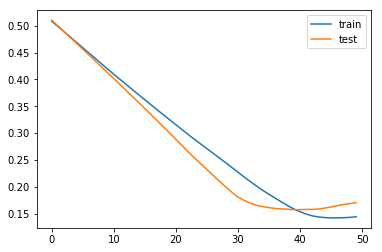

inv_y shape: (25, 5)
Test RMSE: 0.039


In [20]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = raw_df
values = dataset.values
# integer encode direction

# take this out
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features

# debug
print (f'value shape: {values.shape}') #debug

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

# redo this secttion
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
## num_col_to_drop = lstm_input.shape[1] - scaled_data.shape[1]
#### drop the columns at the end
## lstm_input = lstm_input.iloc[:, : - num_col_to_drop]

#above 
#calculate the number of columns to drop
num_col_to_drop =  reframed.shape[1] - dataset.shape[1] -1
# drop the clast columns
reframed = reframed.iloc[:, : -num_col_to_drop]
print (f'reframe shape: {reframed.shape}')
#

# print(reframed.head())
 
# split into train and test sets
values = reframed.values

# redo this section
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

# redone here
# set test_fraction (set it to 0.7)
test_fract = 0.7
split = int(test_fract * len(values))
train = values[:split, :]
test = values [split:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
# change verbose to zo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

# debug
print (f'inv_y shape: {inv_yhat.shape}')

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## Section 4.0 Read infor from newsapi

### 4.1 Sample Code from <br>
https://towardsdatascience.com/get-the-latest-news-using-python-and-performing-analysis-on-it-using-wordclouds-b4541b3b14fd

Import the relevant libraries.

In [ ]:
from newsapi import NewsApiClient

This is for the NewsAPI import. Now initializing a variable for the NewsAPI

In [ ]:
newsapi = NewsApiClient(api_key=api_key)
from pandas.io.json 
import json_normalizeimport pandas as pd

In [ ]:
We will use Beautiful Soup package in Python to help clean up the HTML tags from the data.

In [37]:
from bs4 import BeautifulSoup

Now, let’s see the practical use.

Latest News

To get the latest news:

In [36]:
def top_headlines():    
   country=input("Which country are you interested in?") 
   category=input("""Which category are you interested in? \nHere 
   are the categories to choose from:\nbusiness\nentertainment   
   \ngeneral\nhealth\nscience\ntechnology""")        
   top_headlines =newsapi.get_top_headlines(category=category,
   language='en',country=country)     
   top_headlines=json_normalize(top_headlines['articles'])   
   newdf=top_headlines[["title","url"]]    
   dic=newdf.set_index('title')['url'].to_dict()

Let’s talk about what this piece of code does. I have written a function called top_headlines. I take in two inputs, country and category. When I supply an input to the country you would have to write it in a specific format. The country parameter in the News API follows this code system:

USA is “us”, the United Kingdom is “gb”, India is “in”. For symbols of other countries refer to the link above.

In the code itself, I have mentioned how we can supply an input to the category parameter. “general” for general news, “sports” for sports news, and so on.

Using get_top_headlines you can get the latest news. Now, the output is in JSON so I wanted to convert it into a Dataframe. So, I used the json_normalize method which I imported earlier in this tutorial. I am then storing that into a new Dataframe with only a few select columns from the list of columns returned in the JSON output.

Then I decided that I want to make sense of this news information. I took a used case to see how the opinion of the media changes over time for a particular timeframe. News API has a paid version which offers up to 2 years worth of information. In the free version, you can retrieve up to 30 days worth of news which is the timeframe that I chose as well.

Search for a particular topic

To do this analysis, we need to use this method:

In [ ]:
get_everything(query,language,sort_by='relevancy',from_param,to)

What this means is it gets everything related to a particular search query. Let’s say you want to try to get every piece of information regarding the hottest topic in the world today, COVID-19 or Coronavirus, you would specify so in the “query” parameter in the above function.

The “from_param” parameter and “to” parameter in the above function are the date parameters. It is asking you to specify the timeframe for which you want to get results for the search query. Since I mentioned, I want to get all results for a period of 30 days which is the maximum allowed timeframe for the free version, I will specify the from_param as the day 30 days before today’s date. However, I need to write this in a loop so that I can ensure I am getting every day.

So, I built a date function first which helps me with this.

## creates a list of dates

In [38]:
import datetime
from datetime import datetime, timedelta
def date(base):    
    date_list=[]    
    yr=datetime.today().year    
    if (yr%400)==0 or ((yr%100!=0) and (yr%4==0)):          
        numdays=366        
        date_list.append([base - timedelta(days=x) for x in    
        range(366)])   
    else:        
        numdays=365        
        date_list.append([base - timedelta(days=x) for x in    
        range(365)])    
        newlist=[]    
        for i in date_list:        
           for j in sorted(i):            
               newlist.append(j)    
        return newlist 
def last_30(base):     
    date_list=[base - timedelta(days=x) for x in range(30)]      
    return sorted(date_list)  
def from_dt(x):    
    from_dt=[]    
    for i in range(len(x)):          
        from_dt.append(last_30(datetime.today())[i-1].date())         
    return from_dt        
def to_dt(x):    
    to_dt=[]    
    for i in range(len(x)):        
        to_dt.append(last_30(datetime.today())[i].date())    
    return to_dt
from_list=from_dt(last_30(datetime.today()))
to_list=to_dt(last_30(datetime.today()))

In [42]:
from_list

[datetime.date(2021, 8, 24),
 datetime.date(2021, 7, 26),
 datetime.date(2021, 7, 27),
 datetime.date(2021, 7, 28),
 datetime.date(2021, 7, 29),
 datetime.date(2021, 7, 30),
 datetime.date(2021, 7, 31),
 datetime.date(2021, 8, 1),
 datetime.date(2021, 8, 2),
 datetime.date(2021, 8, 3),
 datetime.date(2021, 8, 4),
 datetime.date(2021, 8, 5),
 datetime.date(2021, 8, 6),
 datetime.date(2021, 8, 7),
 datetime.date(2021, 8, 8),
 datetime.date(2021, 8, 9),
 datetime.date(2021, 8, 10),
 datetime.date(2021, 8, 11),
 datetime.date(2021, 8, 12),
 datetime.date(2021, 8, 13),
 datetime.date(2021, 8, 14),
 datetime.date(2021, 8, 15),
 datetime.date(2021, 8, 16),
 datetime.date(2021, 8, 17),
 datetime.date(2021, 8, 18),
 datetime.date(2021, 8, 19),
 datetime.date(2021, 8, 20),
 datetime.date(2021, 8, 21),
 datetime.date(2021, 8, 22),
 datetime.date(2021, 8, 23)]

The first date function (date) that I have built is a more general date function where I want to use it for a large timeframe if needed. I am getting a list of all days using the first date function. I need only 30 days so I made sure to do that using last_30. This will give me a list of the last 30 days from the current day and time. Moving on to the from_dt function, it is specifically for the from_param for the get_everything function mentioned above. This is the start of the timeframe for which you need all the news articles and to_dt is the end date.

I now have two separate lists for start and end date respectively.

Now we will work on the query parameter which is the search term for the get_everything function.

In [41]:
def func(query): 
    newd={}    
    newdf=pd.DataFrame()    
    for (from_dt,to_dt) in zip(from_list,to_list):           
        all_articles = newsapi.get_everything(q=query,language='en',
        sort_by='relevancy',from_param=from_dt,to=to_dt)          
        d=json_normalize(all_articles['articles'])         
        newdf=d[["url","publishedAt","source.name","author"]]
        dic=newdf.set_index(["source.name","publishedAt","author"]) 
        ["url"].to_dict()        
        for (k,v) in dic.items():            
            page = requests.get(v)            
            html = page.content            
            soup = BeautifulSoup(html, "lxml")            
            text = soup.get_text()            
            d2=soup.find_all("p")            
            newd[k]=re.sub(r'<.+?>',r'',str(d2))     
    return newd

Looping through the zipped version of the from and to lists for the dates, we get a list of all articles for the 30-day timeframe. The reason I chose to loop this is so that I can do analysis for every single day. I then store it in a data frame. I then get the relevant columns and store them back in a dictionary. I want to parse the content in the news URL so that I get the content only from the articles. I used the BeautifulSoup package in Python here to parse the content and get relevant <p> tags where the information resides. Since we are primarily focused on text data here, we need information between these paragraph tags. You can find more information on BeautifulSoup here:
    
Once we have cleaner data, we can now proceed towards the Wordclouds to analyze a pattern.

News Analysis using WordCloud

Now, we move on to the Wordcloud. The part where we can make sense of the data from the news. What are some of the commonly occurring patterns?

In [ ]:
def wordcld(dictionary):        
    newd={}    
    for (k,v) in dictionary.items():        
    if v!='[]':            
        wordcloud = WordCloud().generate(str(dictionary[k]))                
        fig, axes= plt.subplots(figsize=(20,12),clear=True)                     
        plt.imshow(wordcloud, interpolation='bilinear')            
        plt.show()                 
    else:            
        print(str(k[0])+"_"+str(k[1][5:10])+"_"+str(k[1][11:13])              
        +"_"+str(k[1][14:16]) +"_"+str(k[1][17:19])+"_"+str(k[2]))             
        print("Wordcloud Not applicable")
dic=func("Indian Economy")
wordcld(dic)

### 4.2 from NewsAPI Sample

In [25]:
# Initial imports
import os
import pandas as pd
from newsapi import NewsApiClient
from dotenv import load_dotenv
load_dotenv('test1.env')


True

In [23]:
# Reading the News API key enviroment variable
api_key = os.getenv("news_api")



In [24]:
# api_key

'd6be1ce1f0ed4777a2f0ea79b48d576f'

In [25]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)



In [30]:
newsapi

In [26]:
# Fetch top news articles about oil
oil_headlines = newsapi.get_top_headlines(q="oil")
oil_headlines

{'status': 'ok',
 'totalResults': 9,
 'articles': [{'source': {'id': None, 'name': 'Science Daily'},
   'author': None,
   'title': 'Measuring how the Arctic responds to climate change - Science Daily',
   'description': 'The Arctic has been warming more than twice as fast as the rest of the planet. Meanwhile CO2 measurements show substantial increases in the amount of carbon absorbed into and emitted by Arctic plants and soil. Scientists assumed this was playing a large role …',
   'url': 'https://www.sciencedaily.com/releases/2021/08/210824135336.htm',
   'urlToImage': 'https://www.sciencedaily.com/images/scidaily-icon.png',
   'publishedAt': '2021-08-24T19:43:28Z',
   'content': 'Researchers at the University of East Anglia have helped develop a new way to measure how Arctic plants respond to climate change.Over the past few decades, the Arctic has been warming more than twic… [+6907 chars]'},
  {'source': {'id': None, 'name': 'Yahoo Entertainment'},
   'author': 'Ronan Glon',
   't

In [27]:
# Print total articles
print(f"Total articles about oil: {oil_headlines['totalResults']}")

# Show sample article
oil_headlines["articles"]

Total articles about oil: 9


[{'source': {'id': None, 'name': 'Science Daily'},
  'author': None,
  'title': 'Measuring how the Arctic responds to climate change - Science Daily',
  'description': 'The Arctic has been warming more than twice as fast as the rest of the planet. Meanwhile CO2 measurements show substantial increases in the amount of carbon absorbed into and emitted by Arctic plants and soil. Scientists assumed this was playing a large role …',
  'url': 'https://www.sciencedaily.com/releases/2021/08/210824135336.htm',
  'urlToImage': 'https://www.sciencedaily.com/images/scidaily-icon.png',
  'publishedAt': '2021-08-24T19:43:28Z',
  'content': 'Researchers at the University of East Anglia have helped develop a new way to measure how Arctic plants respond to climate change.Over the past few decades, the Arctic has been warming more than twic… [+6907 chars]'},
 {'source': {'id': None, 'name': 'Yahoo Entertainment'},
  'author': 'Ronan Glon',
  'title': 'Ford Focus ST gets factory-fitted adjustable coil-ov

In [28]:
# Transform the response dictionary to a DataFrame
oil_df = pd.DataFrame.from_dict(oil_headlines["articles"])

oil_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Science Daily'}",None,Measuring how the Arctic responds to climate c...,The Arctic has been warming more than twice as...,https://www.sciencedaily.com/releases/2021/08/...,https://www.sciencedaily.com/images/scidaily-i...,2021-08-24T19:43:28Z,Researchers at the University of East Anglia h...
1,"{'id': None, 'name': 'Yahoo Entertainment'}",Ronan Glon,Ford Focus ST gets factory-fitted adjustable c...,Ford stopped selling the Focus in the United S...,https://sg.news.yahoo.com/ford-focus-st-gets-f...,https://s.yimg.com/uu/api/res/1.2/7XF4yQ7qU_no...,2021-08-24T14:00:00Z,See Full Image Gallery &gt;&gt;\r\nFord stoppe...
2,"{'id': 'reuters', 'name': 'Reuters'}","Nidhi Verma, Brijesh Patel",India's July oil imports hit 1-year low on ref...,India's July crude oil imports slumped to thei...,https://www.reuters.com/article/india-oil-idUS...,https://s1.reutersmedia.net/resources_v2/image...,2021-08-24T13:48:00Z,"NEW DELHI, BANGALORE Aug 24 (Reuters) - Indias..."
3,"{'id': 'the-globe-and-mail', 'name': 'The Glob...",None,NDP Leader Jagmeet Singh's promise to end oil ...,"In a election that is clean cut, the clean cut...",https://www.theglobeandmail.com/politics/artic...,https://www.theglobeandmail.com/resizer/FIEjEo...,2021-08-24T11:30:00Z,New Democratic Party leader Jagmeet Singh gree...
4,"{'id': 'news-com-au', 'name': 'News.com.au'}",Nick Bond,Survivor star’s brutal public sledge - NEWS.co...,<p>WARNING: Survivor spoilers below. </p>,https://www.news.com.au/entertainment/tv/reali...,https://content.api.news/v3/images/bin/1375857...,2021-08-24T11:12:37Z,One Survivor contestant just broke all the rul...


In [ ]:
 all_articles = newsapi.get_everything(q=query,language='en',
        sort_by='relevancy',from_param=from_dt,to=to_dt)

In [45]:
 all_articles = newsapi.get_everything(q="google",language='en',
        sort_by='relevancy',from_param="2021-07-24",to="2021-70-30")

In [61]:
all_articles['articles'][0]

{'source': {'id': 'the-verge', 'name': 'The Verge'},
 'author': 'Jon Porter',
 'title': 'Google is shutting down its Android Auto mobile app in favor of Google Assistant',
 'description': 'Google has confirmed that it’s shutting down the standalone “Android Auto for Phone Screens” app with Android 12. It launched in 2019 as a stopgap measure ahead of Google Assistant’s driving mode.',
 'url': 'https://www.theverge.com/2021/8/20/22633755/google-android-auto-for-phone-screens-shutting-down-android-12-google-assistant-driving-mode',
 'urlToImage': 'https://cdn.vox-cdn.com/thumbor/RqOS4nKvRSt2fVr7eK9XOCW0QJY=/0x146:2040x1214/fit-in/1200x630/cdn.vox-cdn.com/uploads/chorus_asset/file/10646769/acastro_180413_1777_android_0001.jpg',
 'publishedAt': '2021-08-20T10:15:12Z',
 'content': 'Android 12 will mark the end of the stopgap app\r\nIllustration by Alex Castro / The Verge\r\nGoogle has confirmed its shutting down the standalone Android Auto for Phone Screens app with Android 12. Ins… [+2043 

In [77]:
all_articles['articles'][0]['publishedAt'][0:10]

'2021-08-20'

#### 4.2.1 fuction to loop through articles and sort description by date

In [80]:
# ddelete
# art_df = pd.DataFrame.from_dict(all_articles['articles'])
art_df.head(2)
art_df['date'] = art_df['publishedAt'].apply (lambda x: x[:10])
art_df['date']

0     2021-08-20
1     2021-07-28
2     2021-07-30
3     2021-08-08
4     2021-08-11
5     2021-08-16
6     2021-07-27
7     2021-08-17
8     2021-08-03
9     2021-08-12
10    2021-08-17
11    2021-08-17
12    2021-08-03
13    2021-08-19
14    2021-08-07
15    2021-07-29
16    2021-08-05
17    2021-08-18
18    2021-08-09
19    2021-07-31
Name: date, dtype: object

In [98]:
def sort_news (in_news):
    '''
    loop through artiles in news api and sort by date.
    create data frame 
    one dataframe with full content
    second with text and date only
    '''
    #convert articles to dataframe
    art_df = pd.DataFrame.from_dict(all_articles['articles'])
    #change to a date string
#     df['age']=df.apply(lambda x: x['age']+3,axis=1)
    # create a column text that concats title descripiton and content
    art_df ['text'] = art_df['title'] + " " + art_df['description'] + " " + art_df['content']
    art_df['date'] = art_df['publishedAt'].apply (lambda x: x[:10])
    #sort by date
    art_df.sort_values (by=['date'], inplace = True)
    #concat all text by date
    text_df = art_df.groupby('date')['text'].apply (lambda x: ','.join (x)).reset_index()
    return art_df, text_df
    
    

In [150]:
art_df, text_df = sort_news(all_articles)
text_df.head(5)

,date,text
0,2021-07-27,Google TV mobile app redesign adds new service...
1,2021-07-28,Google will require coronavirus vaccines for r...
2,2021-07-29,Google Is Booting 'Sugar Daddy' Apps From the ...
3,2021-07-30,Pittsburgh Google contractors ratify deal with...
4,2021-07-31,Apple pulls anti-vax social app over misinform...


In [152]:
text_df['text'][0]

'Google TV mobile app redesign adds new services and recommendations Following last fall’s debut of Google TV, the new user interface for Chromecast devices, Google is today giving its Google TV companion app for Android a makeover. The updated version of the mobile app for Google TV includes an updated user interface, expande… Following last fall’s debut of Google TV, the new user interface for Chromecast devices, Google is today giving its Google TV companion app for Android a makeover. The updated version of the mobile a… [+3311 chars]'

In [145]:
test_text = text_df.copy()
test_text.set_index('date', drop = True, inplace = True)
test_text.head()

,text
date,
2021-07-27,Google TV mobile app redesign adds new service...
2021-07-28,Google will require coronavirus vaccines for r...
2021-07-29,Google Is Booting 'Sugar Daddy' Apps From the ...
2021-07-30,Pittsburgh Google contractors ratify deal with...
2021-07-31,Apple pulls anti-vax social app over misinform...


In [146]:
test_text = text_df.copy()
test_text.set_index('date', drop = True, inplace = True)
test_text.head()

,text
date,
2021-07-27,Google TV mobile app redesign adds new service...
2021-07-28,Google will require coronavirus vaccines for r...
2021-07-29,Google Is Booting 'Sugar Daddy' Apps From the ...
2021-07-30,Pittsburgh Google contractors ratify deal with...
2021-07-31,Apple pulls anti-vax social app over misinform...


#### 4.2.2 combine data with news


In [ ]:
date_index_df

In [148]:
news_price = pd.concat([date_index_df, test_text], axis = 1, join = "outer")
news_price.head(5)

C:\Users\Hassan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,A,AAL,AAP,AAPL,ABBV,text
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.016659,-0.050769,0.000502,-0.010703,-0.010099,NaN
2020-01-06,0.002953,-0.012007,-0.016820,0.008038,0.008199,NaN
2020-01-07,0.003650,-0.003667,-0.011996,-0.005050,-0.005946,NaN
2020-01-08,0.009591,0.022522,-0.011685,0.016229,0.007287,NaN


## 5 Get sentiment. from IBM

In [8]:
# Initial imports
import os
import json
# deoes not work use next cell
# from pandas import json_normalize
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from pandas.io.json import json_normalize
from dotenv import load_dotenv
load_dotenv()
load_dotenv('ibm-credentials.env')
import numpy as np

True

In [10]:
# Get the Tone Analyzer API Key and URL
tone_api = os.getenv("TONE_ANALYZER_APIKEY")
tone_url = os.getenv("TONE_ANALYZER_URL")

In [27]:
# delete
# tone_api
import numpy as np

In [3]:
def init_ibm():
    '''
    code to initialize IBM netork
    '''
    #load environment
    load_dotenv('ibm-credentials.env')
    # Initialize Tone Analyser Client

    # Create authentication object
    authenticator = IAMAuthenticator(tone_api)

    # Create tone_analyzer instance
    tone_analyzer = ToneAnalyzerV3(
        version="2017-09-21",
        authenticator=authenticator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
    )

    # Set the service endpoint
    tone_analyzer.set_service_url(tone_url)
    return tone_analyzer

In [4]:
def create_tone_series(in_text):
    '''
    Takes a text and generates a series of tones based on tonlist
    need to make sure IBM network is alived
    in_text = text to be analzye
    in_tn = tone analyzer
    
    '''
    #set error variabes
    sent_tone = False
    doc_tone = False
    
    #analzye the doe
    tone_analysis = tone_analyzer.tone(
        {"text": in_text},
        content_type="application/json",
        content_language="en",
        accept_language="en",
    ).get_result()
    
    # debug
    # debug print(json.dumps(tone_analysis, indent=2))
    
    #create sentence tone df
    # check if there is a sensettone, then put 
    try:
        sentences_tone_df = json_normalize(
            data=tone_analysis["sentences_tone"],
            record_path=["tones"],
            meta=["sentence_id", "text"],
            )
        sent_tone = True
    except:
        set_tone = False
    
    #change it to a dataframe
    try:
        doc_tone_df = json_normalize(data=tone_analysis["document_tone"], record_path=["tones"])
        doc_tone = True
    except:
        doc_tone = False
        
    
    #creae summary fo all tones
    # debug print (f'sent_done: {sent_tone}\n')
    # debug print (f'doc_tone: {doc_tone}\n')
    if sent_tone:
        tsp_df = sentences_tone_df.groupby('tone_id').sum().transpose()
    elif doc_tone:
        tsp_df = doc_tone_df.groupby('tone_id').sum().transpose()
    else:
        return 'error'

    #define list of tones
    tone_list = ['excited', 'frustrated','impolite', 'polite', 'sad', 'satisfied', 'sympathetic', 
             'anger', 'disgust', 'fear', 'joy', 'sadness',
            'analytical', 'confident', 'tentative',
            'openness_big5', 'conscientiousness_big5', 'extraversion_big5', 'agreeableness_big5',  'emotional_range_big5']
    
    #create tone df with all zeros
    zero_df = pd.DataFrame(0, index=np.arange(1), columns=tone_list)
    #replace falues from tone_df
    zero_df [tsp_df.columns] = tsp_df[tsp_df.columns].values
       
    # debug print (f'zero_df[0]: {zero_df.iloc[0]}\n')  

    return zero_df.iloc[0]

In [12]:
# Initialize Tone Analyser Client

# Create authentication object
authenticator = IAMAuthenticator(tone_api)

# Create tone_analyzer instance
tone_analyzer = ToneAnalyzerV3(
    version="2017-09-21",
    authenticator=authenticator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
)

# Set the service endpoint
tone_analyzer.set_service_url(tone_url)

In [20]:
# Define text to analyze
# test 
text = """
Team, I know that times are tough! 
Product sales have been disappointing for the past three quarters. 
We have a competitive product, but we need to do a better job of selling it!
"""
# text = """Team, I know that times are tough!"""

# Analyze the text's tone with the 'tone()' method.
tone_analysis = tone_analyzer.tone(
    {"text": text},
    content_type="application/json",
    content_language="en",
    accept_language="en",
).get_result()

# Display tone analysis results
print(json.dumps(tone_analysis, indent=2))

{
  "document_tone": {
    "tones": [
      {
        "score": 0.6165,
        "tone_id": "sadness",
        "tone_name": "Sadness"
      },
      {
        "score": 0.829888,
        "tone_id": "analytical",
        "tone_name": "Analytical"
      }
    ]
  },
  "sentences_tone": [
    {
      "sentence_id": 0,
      "text": "Team, I know that times are tough!",
      "tones": [
        {
          "score": 0.801827,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 1,
      "text": "Product sales have been disappointing for the past three quarters.",
      "tones": [
        {
          "score": 0.771241,
          "tone_id": "sadness",
          "tone_name": "Sadness"
        },
        {
          "score": 0.687768,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 2,
      "text": "We have a competitive product, but we need to do a bette

In [21]:
# Document Tones
doc_tone_df = json_normalize(data=tone_analysis["document_tone"], record_path=["tones"])
doc_tone_df

,score,tone_id,tone_name
0,0.616500,sadness,Sadness
1,0.829888,analytical,Analytical


In [22]:
# Sentences Tones
sentences_tone_df = json_normalize(
    data=tone_analysis["sentences_tone"],
    record_path=["tones"],
    meta=["sentence_id", "text"],
)
sentences_tone_df

,score,tone_id,tone_name,sentence_id,text
0,0.801827,analytical,Analytical,0,"Team, I know that times are tough!"
1,0.771241,sadness,Sadness,1,Product sales have been disappointing for the ...
2,0.687768,analytical,Analytical,1,Product sales have been disappointing for the ...
3,0.506763,analytical,Analytical,2,"We have a competitive product, but we need to ..."


In [23]:
test_df = sentences_tone_df.copy()

tone_list = ['excited', 'frustrated','impolite', 'polite', 'sad', 'satisfied', 'sympathetic', 
             'anger', 'disgust', 'fear', 'joy', 'sadness',
            'analytical', 'confident', 'tentative',
            'openness_big5', 'conscientiousness_big5', 'extraversion_big5', 'agreeableness_big5',  'emotional_range_big5']
tone_analyzer = init_ibm()

In [28]:
test_df = sentences_tone_df.copy()
# test_df[tone_list] = test_df['text'].apply(create_tone_series)
# appiled_df = df.apply(lambda row: fn(row.text), axis='columns', result_type='expand') 
test_df[tone_list] = test_df['text'].apply(lambda x: create_tone_series(x))
# # df.merge(df.textcol.apply(lambda s: pd.Series({'feature1':s+1, 'feature2':s-1})), 
#     left_index=True, right_index=True)
# test_df.merge(test_df.textcol.apply(lambda s:create_tone_series(x)), left_index=True, right_index=True)
test_df.head()

,score,tone_id,tone_name,sentence_id,text,excited,frustrated,impolite,polite,sad,...,joy,sadness,analytical,confident,tentative,openness_big5,conscientiousness_big5,extraversion_big5,agreeableness_big5,emotional_range_big5
0,0.801827,analytical,Analytical,0,"Team, I know that times are tough!",0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.801827,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771241,sadness,Sadness,1,Product sales have been disappointing for the ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.771241,0.687768,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.687768,analytical,Analytical,1,Product sales have been disappointing for the ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.771241,0.687768,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.506763,analytical,Analytical,2,"We have a competitive product, but we need to ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.506763,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# from pandas.io.json import json_normalize

In [ ]:
# load_dotenv('ibm-credentials.env')